In [1]:
import math
import numba
import numpy as np
import h5py
import jax
import jax.numpy as jax_np
import pyhmc

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

In [2]:
DEFAULT_PARAMS = np.array([
    -1.777,  # log10epsilon
    11.514,  # log10M1
    -1.412,  # alpha
    0.316,  # gamma
    3.508  # delta
])

## Autograd w/ Jax

In [3]:
@jax.jit
def _my_fun(log10mvir_peak, params):
    log10epsilon = params[0]
    log10M1 = params[1]
    alpha = params[2]
    gamma = params[3]
    delta = params[4]
    
    def _f(x):
        return (
            -jax_np.log10(jax_np.power(10.0, alpha * x) + 1) + 
            delta * 
            jax_np.power(jax_np.log10(1 + jax_np.exp(x)), gamma) / 
            (1.0 + jax_np.exp(jax_np.power(10.0, -x))))


    log10_mh_m1 = log10mvir_peak - log10M1
    return log10epsilon + log10M1 + _f(log10_mh_m1) - _f(0)

_my_fun_grad = jax.jit(jax.vmap(jax.grad(_my_fun, 1), in_axes=(0, None)))


def log10mstar_mpeak(log10mvir_peak, params, grad=False):
    """log10M*(Mvir_peak) from Behroozi et a. (2012, 1207.6105), Eq. 3.
    
    Only valid at z = 0.
    
    Parameters
    ----------
    log10mvir_peak : np.array
        The base-10 log of the peak virial mass of the subhalo.
    params : np.array
        An array of the parameters in the order 
        [log10epsilon, log10M1, alpha, gamma, delta].
    grad : bool, optional
        If True, just Jax to compute the derivatives and return as second return value.
    
    Returns
    -------
    log10mstar : np.array
        The base-10 log of the stellar mass.
    log10mstar_grad : np.array
        The derivative of the output wrt the params. Only present if `grad=True` is set.
    """
    n_params = params.shape[0]
    n_data = log10mvir_peak.shape[0]
    
    if grad:
        return _my_fun(log10mvir_peak, params)._value, _my_fun_grad(log10mvir_peak, params)._value
    else:
        return _my_fun(log10mvir_peak, params)._value

Test this to make sure it runs:

In [4]:
p, pg = log10mstar_mpeak(np.log10(np.array([1e12, 1e14])), DEFAULT_PARAMS, grad=True)
print(p, pg)

/Users/Matt/miniconda3/envs/anl-py37/lib/python3.7/site-packages/jax/lib/xla_bridge.py:115: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


[10.428106 11.204406] [[ 1.0000000e+00  4.4507146e-02 -8.2999207e-02 -1.9589996e-01
   1.3438046e-01]
 [ 1.0000000e+00  7.8672653e-01 -7.6760008e-04  9.7131228e-01
   3.3252856e-01]]


## Binning Function w/ Deriv

In [5]:
@numba.njit
def kernel_hist_with_derivs(log10mstar, log10mstar_jac, bins, sigma):
    """Compute a histogram of the input stellar masses along with the 
    derivatives of this histogram using the input jacobian.
    
    Parameters
    ----------
    log10mstar : np.array, shape (n_data,)
        The input stellar masses to histogram.
    log10mstar_jac : np.array, shape (n_data, n_params)
        The jacobian derivs of the input stellar masses wrt the params.
    bins : np.array, shape (n_bins+1,)
        An array of the bin edges.
    sigma : float or np.array of shape (n_data,)
        The width of the Gaussian kernel to use for the bins. Should be 
        roughly the scatter in the stellar to halo mass relation with 
        any observational errors. FIXME: We need to output a derivative 
        wrt this as well.
    
    Returns
    -------
    hist : np.array, shape (n_bins,)
        The output histogram.
    hist_jac : np.array, shape (n_bins, n_params)
        The derivatives of the histogram bins wrt the params.
    """
    n_bins = bins.shape[0]-1
    n_params = log10mstar_jac.shape[1]
    n_data = log10mstar.shape[0]
    
    hist = np.zeros(n_bins)
    hist_jac = np.zeros((n_bins, n_params))

    sigma_sqrt2 = sigma * math.sqrt(2)
    sigma_sqrt2pi = sigma_sqrt2 * math.sqrt(math.pi)

    for i in range(n_data):
        x = log10mstar[i]

        z = (x - bins[0]) / sigma_sqrt2
        last_cdf = (1 + math.erf(z)) / 2
        last_cdf_deriv = math.exp(-z*z) / sigma_sqrt2pi

        for j in range(n_bins):
            z = (x -  bins[j+1]) / sigma_sqrt2
            new_cdf = (1 + math.erf(z)) / 2
            new_cdf_deriv = math.exp(-z*z) / sigma_sqrt2pi

            # get the hist weight
            weight = last_cdf - new_cdf
            hist[j] += weight
            
            # do the derivs
            for k in range(n_params):
                hist_jac[j, k] += (last_cdf_deriv - new_cdf_deriv) * log10mstar_jac[i, k]

            last_cdf = new_cdf
            last_cdf_deriv = new_cdf_deriv
    
    return hist, hist_jac

## Run on Data!

In [6]:
# alright, now lets read some real data!
with h5py.File('halos_Lb125_1024.h5', 'r') as hf:
    data = hf['halos'][:]
    
msk = np.log10(data['mpeak']) > 10.0
data = data[msk]

In [7]:
log10mstar = log10mstar_mpeak(np.log10(data['mpeak']), DEFAULT_PARAMS)

### Make a plot of the data

<Figure size 432x288 with 0 Axes>

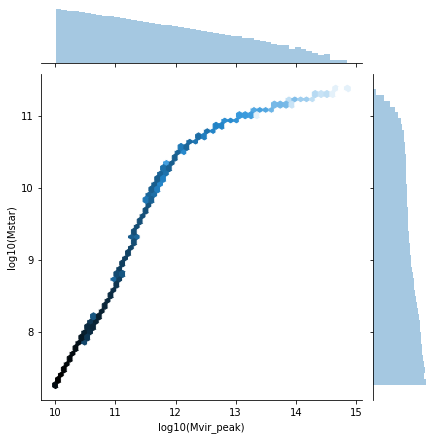

In [8]:
plt.figure()
jg = sns.jointplot(
    np.log10(data['mpeak']), 
    log10mstar, 
    kind='hex', bins='log', 
    marginal_kws={'hist_kws': {'log': True}},
    )
jg.set_axis_labels('log10(Mvir_peak)', 'log10(Mstar)')

### Now let's try using our function above

In [11]:
%%time

vals, jac = log10mstar_mpeak(np.log10(data['mpeak']), DEFAULT_PARAMS, grad=True)

CPU times: user 170 ms, sys: 7.74 ms, total: 178 ms
Wall time: 96.5 ms


In [12]:
%%time

bins = np.linspace(9, 13, 25)
locs = bins[:-1] + (bins[1] - bins[0])/2

h, jac_h = kernel_hist_with_derivs(
    vals, 
    jac, 
    bins, 
    0.2)

CPU times: user 1.42 s, sys: 46.8 ms, total: 1.47 s
Wall time: 1.49 s


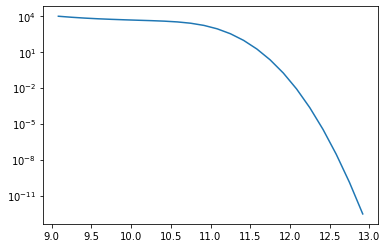

In [13]:
plt.figure()
plt.semilogy(locs, h)

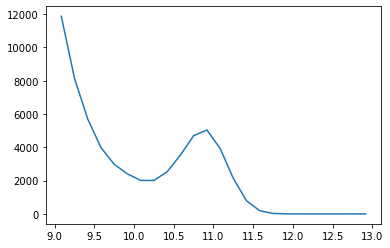

In [14]:
plt.figure()
plt.plot(locs, jac_h[:, 0])

## And finally, some HMC

In [17]:
bins = np.linspace(9, 13, 25)
locs = bins[:-1] + (bins[1] - bins[0])/2

def logprob_and_grad(params, log10mvir_peak, param_scales, h_meas, h_err):
    p = params * param_scales
    vals, jac = log10mstar_mpeak(log10mvir_peak, p, grad=True)
    h_mod, jac_h = kernel_hist_with_derivs(
        vals, 
        jac, 
        bins, 
        0.2)
    chi = (h_meas - h_mod) / h_err
    return -0.5 * np.sum(chi**2), -np.sum(chi * jac_h, axis=0)

In [ ]:
h_err = np.sqrt(h)